# DATA INGESTION

# Getting The Data

### Setup IG Session

In [2]:
pip install trading_ig pandas munch tenacity

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade ta

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install psycopg2

  Using cached psycopg2-2.9.3-cp39-cp39-win_amd64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
import sys

sys.path.append("/ScalpFX/")
from src.utils.IG import IG

In [8]:
from utils.IG import IG

_IG = IG()
config_live = _IG.getLoginConfig('live')

IG - Instantiated


In [9]:
ig_service_live = _IG.getIgService(config_live)
_IG.getIgAccountDetails(ig_service_live)

{'accountType': 'CFD',
 'accountInfo': {'balance': 28.08,
  'deposit': 0.0,
  'profitLoss': 0.0,
  'available': 28.08},
 'currencyIsoCode': 'USD',
 'currencySymbol': '$',
 'currentAccountId': 'QM0EM',
 'lightstreamerEndpoint': 'https://apd.marketdatasystems.com',
 'accounts': [{'accountId': 'QM0EM',
   'accountName': 'CFD Live',
   'preferred': True,
   'accountType': 'CFD'}],
 'clientId': '104831189',
 'timezoneOffset': 8,
 'hasActiveDemoAccounts': True,
 'hasActiveLiveAccounts': True,
 'trailingStopsEnabled': False,
 'reroutingEnvironment': None,
 'dealingEnabled': True}

### Get the Historical Data of GBP/USD Mini

In [10]:
TARGET_EPIC = 'CS.D.GBPUSD.MINI.IP'
RESOLUTION = '15Min'
PREVIOUS_MONTHS_COUNT_FROM_TODAY = 4

In [11]:
# Get today's next day date as End Date, and previous X month(s) from today as Start Date

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

end_date = datetime.combine(date.today(), datetime.max.time())
start_date = datetime.combine(date.today() - relativedelta(months=PREVIOUS_MONTHS_COUNT_FROM_TODAY), datetime.min.time())

print(f'''End: {end_date}''')
print(type(end_date))
print(f'''Start: {start_date}''')

End: 2022-06-11 23:59:59.999999
<class 'datetime.datetime'>
Start: 2022-02-11 00:00:00


In [9]:
LOCAL_READ = False

try:
    history = _IG.getHistoricalPricesByDuration(ig_service_live, {'TARGET_EPIC':TARGET_EPIC, 
                                                                  'RESOLUTION':RESOLUTION, 
                                                                  'start_date':start_date, 
                                                                  'end_date':end_date})
    history['prices']
except Exception as e:
    print(e)
    LOCAL_READ = True

In [10]:
# If API failed, read data from previously saved Excel File

from os import listdir
from os.path import isfile, join
    
def readLatestFile(TARGET_EPIC, RESOLUTION, DATA_PATH):
    onlyfiles = [f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]
    onlyfiles.sort(reverse=True)
    for fileName in onlyfiles:
        if TARGET_EPIC in fileName and RESOLUTION in fileName:
            return fileName
        
    return ''

In [11]:
import pandas as pd

DATA_PATH = '../data/'

if LOCAL_READ:
    print(f'''{DATA_PATH}{readLatestFile(TARGET_EPIC, RESOLUTION, DATA_PATH)}''')
    df_history = pd.read_excel(f'''{DATA_PATH}{readLatestFile(TARGET_EPIC, RESOLUTION, DATA_PATH)}''',
                               index_col=[0], header=[0,1])
    df_history = df_history.rename(columns={df_history.columns[0][1]:''}, level=1)
else:
    print('Retrieved from API')
    df_history = pd.DataFrame.from_dict(history['prices'])
    df_history = df_history.reset_index()
    
df_history

Retrieved from API


DateTime      bid                                 ask  \
                             Open     High      Low    Close     Open   
0    2022-02-11 00:00:00  1.36381  1.36381  1.36262  1.36280  1.36396   
1    2022-02-11 00:15:00  1.36282  1.36334  1.36228  1.36240  1.36291   
2    2022-02-11 00:30:00  1.36241  1.36301  1.36210  1.36284  1.36256   
3    2022-02-11 00:45:00  1.36285  1.36286  1.35950  1.36116  1.36294   
4    2022-02-11 01:00:00  1.36117  1.36203  1.36081  1.36150  1.36126   
...                  ...      ...      ...      ...      ...      ...   
8331 2022-06-11 03:45:00  1.23127  1.23156  1.23085  1.23100  1.23142   
8332 2022-06-11 04:00:00  1.23099  1.23141  1.23098  1.23132  1.23114   
8333 2022-06-11 04:15:00  1.23131  1.23131  1.23074  1.23084  1.23146   
8334 2022-06-11 04:30:00  1.23082  1.23136  1.23059  1.23130  1.23097   
8335 2022-06-11 04:45:00  1.23129  1.23179  1.23041  1.23142  1.23144   

                                last                        
         High      Low    Close Open High Low Close Volume  
0     1.36396  1.36273  1.36295  NaN  NaN NaN   NaN   2292  
1     1.36348  1.36243  1.36255  NaN  NaN NaN   NaN   2019  
2     1.36313  1.36219  1.36293  NaN  NaN NaN   NaN   1551  
3     1.36295  1.35961  1.36125  NaN  NaN NaN   NaN   4921  
4     1.36217  1.36093  1.36165  NaN  NaN NaN   NaN   3723  
...       ...      ...      ...  ...  ...  ..   ...    ...  
8331  1.23169  1.23100  1.23115  NaN  NaN NaN   NaN   2081  
8332  1.23156  1.23113  1.23147  NaN  NaN NaN   NaN    905  
8333  1.23148  1.23089  1.23099  NaN  NaN NaN   NaN    629  
8334  1.23151  1.23074  1.23145  NaN  NaN NaN   NaN    606  
8335  1.23289  1.23109  1.23212  NaN  NaN NaN   NaN   1814  

[8336 rows x 14 columns]

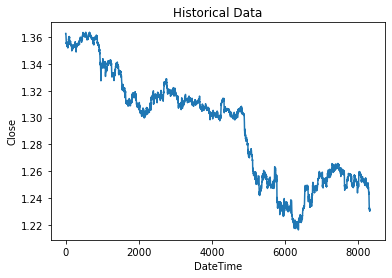

<Figure size 1152x648 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

plt.plot(df_history[('bid', 'Close')])

plt.xlabel("DateTime")
plt.ylabel("Close")
plt.title("Historical Data")

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(16)

plt.show()

In [13]:
df_history = df_history.sort_values(by=['DateTime'], ascending=False)
df_history

DateTime      bid                                 ask  \
                             Open     High      Low    Close     Open   
8335 2022-06-11 04:45:00  1.23129  1.23179  1.23041  1.23142  1.23144   
8334 2022-06-11 04:30:00  1.23082  1.23136  1.23059  1.23130  1.23097   
8333 2022-06-11 04:15:00  1.23131  1.23131  1.23074  1.23084  1.23146   
8332 2022-06-11 04:00:00  1.23099  1.23141  1.23098  1.23132  1.23114   
8331 2022-06-11 03:45:00  1.23127  1.23156  1.23085  1.23100  1.23142   
...                  ...      ...      ...      ...      ...      ...   
4    2022-02-11 01:00:00  1.36117  1.36203  1.36081  1.36150  1.36126   
3    2022-02-11 00:45:00  1.36285  1.36286  1.35950  1.36116  1.36294   
2    2022-02-11 00:30:00  1.36241  1.36301  1.36210  1.36284  1.36256   
1    2022-02-11 00:15:00  1.36282  1.36334  1.36228  1.36240  1.36291   
0    2022-02-11 00:00:00  1.36381  1.36381  1.36262  1.36280  1.36396   

                                last                        
         High      Low    Close Open High Low Close Volume  
8335  1.23289  1.23109  1.23212  NaN  NaN NaN   NaN   1814  
8334  1.23151  1.23074  1.23145  NaN  NaN NaN   NaN    606  
8333  1.23148  1.23089  1.23099  NaN  NaN NaN   NaN    629  
8332  1.23156  1.23113  1.23147  NaN  NaN NaN   NaN    905  
8331  1.23169  1.23100  1.23115  NaN  NaN NaN   NaN   2081  
...       ...      ...      ...  ...  ...  ..   ...    ...  
4     1.36217  1.36093  1.36165  NaN  NaN NaN   NaN   3723  
3     1.36295  1.35961  1.36125  NaN  NaN NaN   NaN   4921  
2     1.36313  1.36219  1.36293  NaN  NaN NaN   NaN   1551  
1     1.36348  1.36243  1.36255  NaN  NaN NaN   NaN   2019  
0     1.36396  1.36273  1.36295  NaN  NaN NaN   NaN   2292  

[8336 rows x 14 columns]

In [14]:
df_history.describe()

bid                                                 ask  \
              Open         High          Low        Close         Open   
count  8336.000000  8336.000000  8336.000000  8336.000000  8336.000000   
mean      1.292365     1.292877     1.291838     1.292352     1.292569   
std       0.040013     0.039965     0.040064     0.040013     0.040018   
min       1.216400     1.217630     1.215480     1.216370     1.216550   
25%       1.254188     1.254827     1.253680     1.254167     1.254350   
50%       1.304040     1.304540     1.303645     1.304050     1.304275   
75%       1.317063     1.317545     1.316510     1.317063     1.317263   
max       1.363810     1.364220     1.363100     1.363610     1.363960   

                                             last                               
              High          Low        Close Open High  Low Close       Volume  
count  8336.000000  8336.000000  8336.000000  0.0  0.0  0.0   0.0  8336.000000  
mean      1.293080     1.292041     1.292553  NaN  NaN  NaN   NaN  1907.989923  
std       0.039969     0.040069     0.040017  NaN  NaN  NaN   NaN   923.083018  
min       1.217720     1.215630     1.216520  NaN  NaN  NaN   NaN     2.000000  
25%       1.254990     1.253837     1.254348  NaN  NaN  NaN   NaN  1275.000000  
50%       1.304805     1.303845     1.304255  NaN  NaN  NaN   NaN  1801.500000  
75%       1.317755     1.316673     1.317273  NaN  NaN  NaN   NaN  2401.000000  
max       1.364370     1.363230     1.363760  NaN  NaN  NaN   NaN  7683.000000

### Calculate the Mid values

In [20]:
pip install round2

Note: you may need to restart the kernel to use updated packages.


In [21]:
from round2 import round2

def averageTwoFloats(x,y):
    return round2((x+y)/2, 5)

In [22]:
df_history[('mid', 'Open')]  = df_history.apply(lambda x: averageTwoFloats(x[('bid', 'Open')],  x[('ask', 'Open')]), axis=1)
df_history[('mid', 'High')]  = df_history.apply(lambda x: averageTwoFloats(x[('bid', 'High')],  x[('ask', 'High')]), axis=1)
df_history[('mid', 'Low')]   = df_history.apply(lambda x: averageTwoFloats(x[('bid', 'Low')],   x[('ask', 'Low')]), axis=1)
df_history[('mid', 'Close')] = df_history.apply(lambda x: averageTwoFloats(x[('bid', 'Close')], x[('ask', 'Close')]), axis=1)

df_history

DateTime      bid                                 ask  \
                             Open     High      Low    Close     Open   
8335 2022-06-11 04:45:00  1.23129  1.23179  1.23041  1.23142  1.23144   
8334 2022-06-11 04:30:00  1.23082  1.23136  1.23059  1.23130  1.23097   
8333 2022-06-11 04:15:00  1.23131  1.23131  1.23074  1.23084  1.23146   
8332 2022-06-11 04:00:00  1.23099  1.23141  1.23098  1.23132  1.23114   
8331 2022-06-11 03:45:00  1.23127  1.23156  1.23085  1.23100  1.23142   
...                  ...      ...      ...      ...      ...      ...   
4    2022-02-11 01:00:00  1.36117  1.36203  1.36081  1.36150  1.36126   
3    2022-02-11 00:45:00  1.36285  1.36286  1.35950  1.36116  1.36294   
2    2022-02-11 00:30:00  1.36241  1.36301  1.36210  1.36284  1.36256   
1    2022-02-11 00:15:00  1.36282  1.36334  1.36228  1.36240  1.36291   
0    2022-02-11 00:00:00  1.36381  1.36381  1.36262  1.36280  1.36396   

                                last                            mid           \
         High      Low    Close Open High Low Close Volume     Open     High   
8335  1.23289  1.23109  1.23212  NaN  NaN NaN   NaN   1814  1.23137  1.23234   
8334  1.23151  1.23074  1.23145  NaN  NaN NaN   NaN    606  1.23089  1.23144   
8333  1.23148  1.23089  1.23099  NaN  NaN NaN   NaN    629  1.23139  1.23140   
8332  1.23156  1.23113  1.23147  NaN  NaN NaN   NaN    905  1.23107  1.23149   
8331  1.23169  1.23100  1.23115  NaN  NaN NaN   NaN   2081  1.23135  1.23163   
...       ...      ...      ...  ...  ...  ..   ...    ...      ...      ...   
4     1.36217  1.36093  1.36165  NaN  NaN NaN   NaN   3723  1.36122  1.36210   
3     1.36295  1.35961  1.36125  NaN  NaN NaN   NaN   4921  1.36290  1.36291   
2     1.36313  1.36219  1.36293  NaN  NaN NaN   NaN   1551  1.36249  1.36307   
1     1.36348  1.36243  1.36255  NaN  NaN NaN   NaN   2019  1.36287  1.36341   
0     1.36396  1.36273  1.36295  NaN  NaN NaN   NaN   2292  1.36389  1.36389   

                        
          Low    Close  
8335  1.23075  1.23177  
8334  1.23067  1.23137  
8333  1.23082  1.23092  
8332  1.23106  1.23140  
8331  1.23093  1.23108  
...       ...      ...  
4     1.36087  1.36158  
3     1.35955  1.36121  
2     1.36215  1.36289  
1     1.36236  1.36248  
0     1.36268  1.36288  

[8336 rows x 18 columns]

In [23]:
df = df_history[[('DateTime', ''), ('mid', 'Open'), ('mid', 'High'), ('mid', 'Low'), ('mid', 'Close'), ('last', 'Volume')]].copy()
df

DateTime      mid                              last
                             Open     High      Low    Close Volume
8335 2022-06-11 04:45:00  1.23137  1.23234  1.23075  1.23177   1814
8334 2022-06-11 04:30:00  1.23089  1.23144  1.23067  1.23137    606
8333 2022-06-11 04:15:00  1.23139  1.23140  1.23082  1.23092    629
8332 2022-06-11 04:00:00  1.23107  1.23149  1.23106  1.23140    905
8331 2022-06-11 03:45:00  1.23135  1.23163  1.23093  1.23108   2081
...                  ...      ...      ...      ...      ...    ...
4    2022-02-11 01:00:00  1.36122  1.36210  1.36087  1.36158   3723
3    2022-02-11 00:45:00  1.36290  1.36291  1.35955  1.36121   4921
2    2022-02-11 00:30:00  1.36249  1.36307  1.36215  1.36289   1551
1    2022-02-11 00:15:00  1.36287  1.36341  1.36236  1.36248   2019
0    2022-02-11 00:00:00  1.36389  1.36389  1.36268  1.36288   2292

[8336 rows x 6 columns]

In [24]:
df.columns = df.columns.droplevel()
df.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
df

,DateTime,Open,High,Low,Close,Volume
8335,2022-06-11 04:45:00,1.23137,1.23234,1.23075,1.23177,1814
8334,2022-06-11 04:30:00,1.23089,1.23144,1.23067,1.23137,606
8333,2022-06-11 04:15:00,1.23139,1.23140,1.23082,1.23092,629
8332,2022-06-11 04:00:00,1.23107,1.23149,1.23106,1.23140,905
8331,2022-06-11 03:45:00,1.23135,1.23163,1.23093,1.23108,2081
...,...,...,...,...,...,...
4,2022-02-11 01:00:00,1.36122,1.36210,1.36087,1.36158,3723
3,2022-02-11 00:45:00,1.36290,1.36291,1.35955,1.36121,4921
2,2022-02-11 00:30:00,1.36249,1.36307,1.36215,1.36289,1551
1,2022-02-11 00:15:00,1.36287,1.36341,1.36236,1.36248,2019


### Push to Database

In [26]:
import psycopg2

In [53]:
conn = psycopg2.connect(
    host="127.0.0.1",
    dbname="IG_TRADING",
    user="postgres",
    password="password")

conn

<connection object at 0x000001D06210D6A0; dsn: 'user=postgres password=xxx dbname=IG_TRADING host=127.0.0.1', closed: 0>

In [54]:
cur = conn.cursor()
cur

<cursor object at 0x000001D062370580; closed: 0>

In [55]:
cur.execute('SELECT MAX(datetime) FROM "FOREX_MINI"."GBPUSD_15MIN"')

In [59]:
res = cur.fetchone()
print(res)

if res is None:
    print("Kosong")

None
Kosong


In [33]:
cur.close()

In [34]:
conn.close()

In [36]:
cur

<cursor object at 0x000001D0620A5F20; closed: -1>

In [37]:
conn

<connection object at 0x000001D06210D590; dsn: 'user=postgres password=xxx dbname=IG_TRADING host=127.0.0.1', closed: 1>